# Step 1: Domain Setup and Container Creation

This notebook walks through loading and examining the shapefile, then creates a SwimContainer to hold all project data.

The SwimContainer is the heart of SWIM-RS data management. It stores all project data (geometries, meteorology, remote sensing, properties, derived products) in a single `.swim` file with full provenance tracking.

In this notebook you will:
1. Load and explore the shapefile
2. Create a SwimContainer from the shapefile
3. Understand the container structure and API

## 1. Load Necessary Libraries

To work with geospatial data, we'll primarily use `geopandas` along with `matplotlib` for visualization.

In [1]:
import os
import sys

import geopandas as gpd
import matplotlib.pyplot as plt

root = os.path.abspath('../..')
sys.path.append(root)

%matplotlib inline

## 2. Load the Shapefile

Using `geopandas`, we can load the shapefile and inspect its structure. It contains data clipped from the Montana [Statewide Irrigation Dataset](https://mslservices.mt.gov/Geographic_Information/Data/DataList/datalist_Details.aspx?did=%7Bf33bc611-8d4e-4d92-ae99-49762dec888b%7D).

In [2]:
project_dir = os.path.abspath('.')
shapefile_path = os.path.join(project_dir, 'data', 'gis', 'mt_sid_boulder.shp')

gdf = gpd.read_file(shapefile_path)

# Display the first few rows of the GeoDataFrame to examine structure and attributes
print(f'{gdf.shape[0]} fields')
gdf.head()

78 fields


,FID_1,SOURCECODE,COUNTY_NO,COUNTYNAME,ITYPE,USAGE,MAPPEDBY,New_Acres,STATE,geometry
0,043_000153,MTDNRC,43.0,Jefferson,F,3.0,DR,95.855676,MT,"POLYGON ((-1225214.579 2666534.229, -1225225.2..."
1,043_000154,MTDNRC,43.0,Jefferson,F,3.0,DR,33.753460,MT,"POLYGON ((-1225492.111 2666707.885, -1225489.5..."
2,043_000155,MTDNRC,43.0,Jefferson,F,2.0,DR,25.633212,MT,"POLYGON ((-1226684.776 2668506.952, -1226702.6..."
3,043_000156,MTDNRC,43.0,Jefferson,F,2.0,DR,47.997675,MT,"POLYGON ((-1226650.529 2669296.308, -1226631.5..."
4,043_000157,MTDNRC,43.0,Jefferson,S,3.0,DR,49.050241,MT,"POLYGON ((-1225665.351 2668805.553, -1225673.4..."


## 3. Display the Shapefile Geometry

Now, we'll plot the shapefile to get a visual overview of the spatial data it contains.

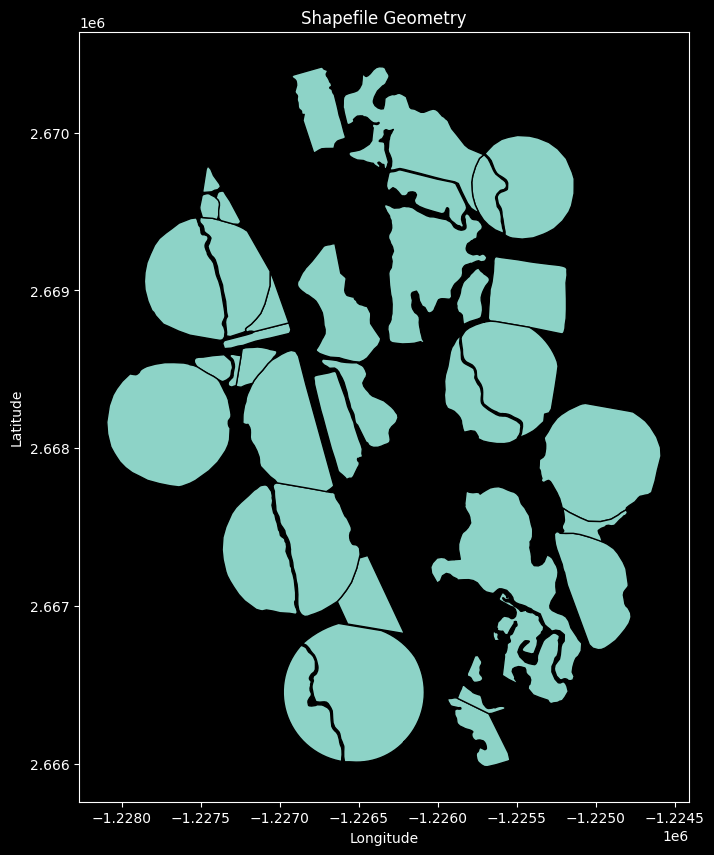

In [3]:
gdf.plot(figsize=(10, 10), edgecolor='black')
plt.title('Shapefile Geometry')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 4. Check the EPSG Code

To confirm the projection, we'll display the EPSG code of the shapefile. We want the projection for the project in Albers Equal Area, so I reprojected the SID into 5071 in a GIS.

In [4]:
epsg_code = gdf.crs
print(f"EPSG Code: {epsg_code}")

EPSG Code: EPSG:5071


## 5. List the Attributes (Fields) in the Shapefile

List all fields (attributes) within the shapefile to see the available data. There is valuable information, though we only really need a unique ID, for which we can use 'FID_1'.

In [5]:
attributes = gdf.columns
print('Attributes in shapefile:')
for attribute in attributes:
    print(attribute)

Attributes in shapefile:
FID_1
SOURCECODE
COUNTY_NO
COUNTYNAME
ITYPE
USAGE
MAPPEDBY
New_Acres
STATE
geometry


## 6. Display Shapefile with a Basemap

In this cell, we will load the shapefile and plot it with a basemap for better geographical context. To add the basemap, we use `contextily`, which provides tiles from various web-based map providers.

HTTPError: Connection reset by peer too many times. Last message was: 401 Error: Unauthorized for url: https://tiles.stadiamaps.com/tiles/stamen_toner_labels/14/3098/5822.png

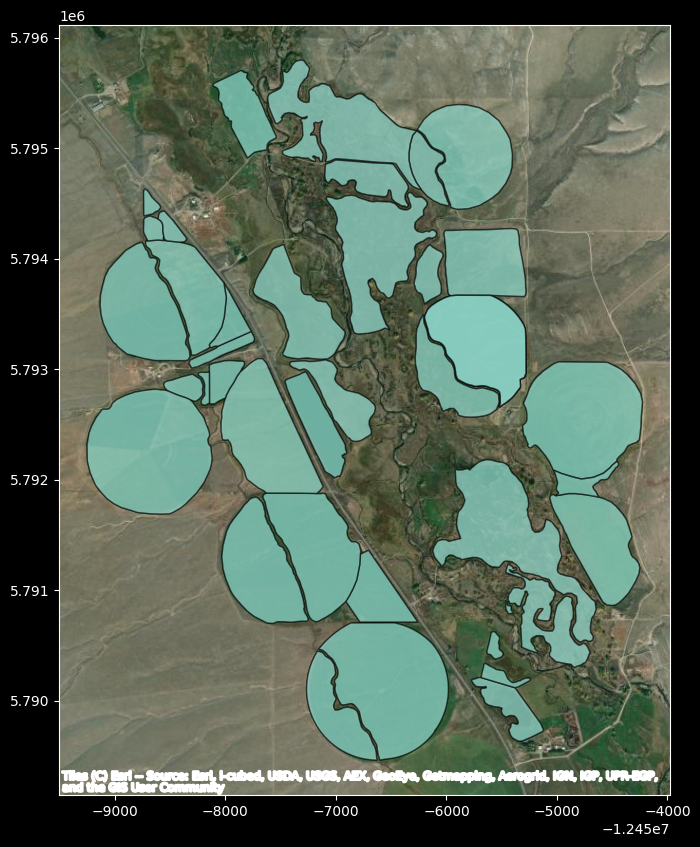

In [15]:
import contextily as ctx

# Check if the shapefile's CRS is in meters (projected); contextily basemaps are in Web Mercator (EPSG:3857)
gdf_plot = gdf.copy()
if gdf_plot.crs.to_string() != 'EPSG:3857':
    gdf_plot = gdf_plot.to_crs(epsg=3857)  # Reproject to Web Mercator if needed

fig, ax = plt.subplots(figsize=(10, 10))
gdf_plot.plot(ax=ax, edgecolor='black', alpha=0.5)

# Hybrid basemap: satellite imagery + labels overlay
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
ctx.add_basemap(ax, source=ctx.providers.Stadia.StamenTonerLabels, alpha=0.8)

plt.title("Shapefile with Basemap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## 7. Create the SwimContainer

Now we create a SwimContainer from our shapefile. The container will:
- Store the field geometries
- Define the time range for our analysis
- Serve as the central data store for all subsequent data (meteorology, remote sensing, etc.)

The container uses Zarr storage format internally, providing efficient access to large arrays with chunking and compression.

In [13]:
from swimrs.container import SwimContainer

container_path = os.path.join(project_dir, 'data', '1_Boulder.swim')

container = SwimContainer.create(
    container_path,
    fields_shapefile=shapefile_path,
    uid_column="FID_1",
    start_date="2004-01-01",
    end_date="2022-12-31",
    project_name="1_Boulder",
    overwrite=True,
)

print('Ignore the UnstableSpecificationWarning; it should clear up in future zarr python package releases')

Created container: file:///home/dgketchum/code/swim-rs/examples/1_Boulder/data/1_Boulder.swim (78 fields, 6940 days)
Ignore the UnstableSpecificationWarning; it should clear up in future zarr python package releases


/home/dgketchum/miniconda/envs/swim/lib/python3.11/site-packages/zarr/core/dtype/npy/bytes.py:1143: UnstableSpecificationWarning: The data type (VariableLengthBytes()) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)


## 8. Explore the Container

Let's examine what the container knows about our project.

In [9]:
print(f"Project: {container.project_name}")
print(f"Number of fields: {container.n_fields}")
print(f"Date range: {container.start_date} to {container.end_date}")
print(f"Number of days: {container.n_days}")
print(f"\nField UIDs (first 10): {container.field_uids[:10]}")

Project: 1_Boulder
Number of fields: 78
Date range: 2004-01-01 00:00:00 to 2022-12-31 00:00:00
Number of days: 6940

Field UIDs (first 10): ['043_000153', '043_000154', '043_000155', '043_000156', '043_000157', '043_000158', '043_000159', '043_000160', '043_000161', '043_000162']


## 9. Check Container Status

The container provides a status query to show what data has been ingested. Right now it should be empty except for the geometry.

In [10]:
print(container.query.status())

CONTAINER STATUS
  URI: file:///home/dgketchum/code/swim-rs/examples/1_Boulder/data/1_Boulder.swim
  Fields: 78
  Date range: 2004-01-01 to 2022-12-31
  Days: 6940

DATA PATHS:
----------------------------------------

  geometry/
    area_m2: shape=(78,), 100.0% valid
    lat: shape=(78,), 100.0% valid
    lon: shape=(78,), 100.0% valid
    properties/COUNTYNAME: shape=(78,), 100.0% non-empty
    properties/COUNTY_NO: shape=(78,), 100.0% valid
    properties/ITYPE: shape=(78,), 100.0% non-empty
    properties/MAPPEDBY: shape=(78,), 100.0% non-empty
    properties/New_Acres: shape=(78,), 100.0% valid
    properties/SOURCECODE: shape=(78,), 100.0% non-empty
    properties/STATE: shape=(78,), 100.0% non-empty
    properties/USAGE: shape=(78,), 100.0% valid
    uid: shape=(78,), 100.0% non-empty
    wkb: shape=(78,), 100.0% non-empty

  time/
    daily: shape=(6940,), dtype=datetime64[ns]

METEOROLOGY CHECK:
----------------------------------------
  ✗ GridMET ETo: NOT FOUND
  ✗ GridMET P

## 10. Save and Close

Save the container and close it. We'll reopen it in the next notebooks to ingest data.

In [11]:
container.save()
container.close()

print(f"Container saved to: {container_path}")
print("\nNext: Run notebook 02 to extract data (if you have Earth Engine access)")
print("      Or skip to notebook 03 to ingest pre-built data")

Container saved to: /home/dgketchum/code/swim-rs/examples/1_Boulder/data/1_Boulder.swim

Next: Run notebook 02 to extract data (if you have Earth Engine access)
      Or skip to notebook 03 to ingest pre-built data
